In [44]:
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
# import tensorflow as tf
import warnings
import sqlite3


In [45]:
plt.style.use('fivethirtyeight')
warnings.filterwarnings("ignore")
conn = sqlite3.connect('dwh.db')
c = conn.cursor()

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 3000)

In [46]:
#get the stock quote
df = pd.read_sql_query("SELECT * FROM XRP", conn)
df['avg'] = (df['xrp_high'] + df['xrp_low']) / 2
df2=(df[['avg','datum']])

print(df2.shape)

print(df2.dtypes)

(1514, 2)
avg      float64
datum     object
dtype: object


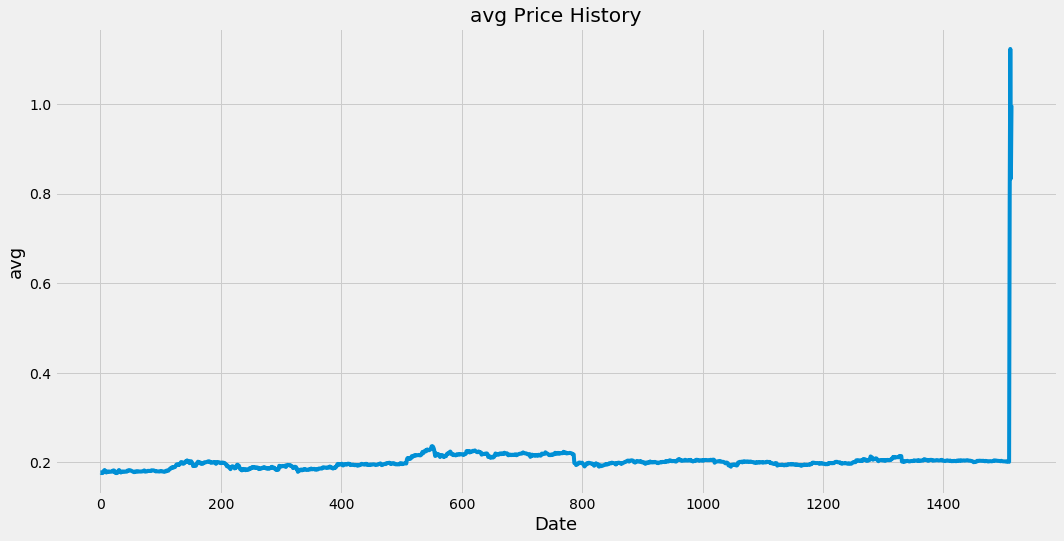

In [47]:
plt.figure(figsize=(16,8))
plt.title('avg Price History')
plt.plot(df2['avg'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('avg', fontsize=18)
plt.show()

In [48]:
data = df2.filter(['avg'])
dataset = data.values

In [49]:
# get the number of rows to train the model on .8 = 80% of the data
training_data_len = math.ceil(len(dataset)*.8)
print(training_data_len)

1212


In [50]:
# scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
print(scaled_data)

[[0.00158361]
 [0.0016364 ]
 [0.        ]
 ...
 [1.        ]
 [0.69483742]
 [0.8667652 ]]


In [51]:
# create the training dataset
# create the scaled training dataset
train_data = scaled_data[0:training_data_len , :]

# split the data into x_train and y_train datasets
x_train =[]
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i <= 60:
        print(x_train)
        print(y_train)
        print()

[array([0.00158361, 0.0016364 , 0.        , 0.00015836, 0.00021115,
       0.00343117, 0.00591216, 0.00728463, 0.00348395, 0.00348395,
       0.00131968, 0.00300887, 0.00395904, 0.00290329, 0.00274493,
       0.00374789, 0.0036951 , 0.00322002, 0.0032728 , 0.00332559,
       0.00348395, 0.00596495, 0.00538429, 0.00596495, 0.00158361,
       0.0016364 , 0.        , 0.00015836, 0.00021115, 0.00343117,
       0.00591216, 0.00728463, 0.00348395, 0.00348395, 0.00131968,
       0.00300887, 0.00395904, 0.00290329, 0.00274493, 0.00374789,
       0.0036951 , 0.00322002, 0.0032728 , 0.00332559, 0.00348395,
       0.00596495, 0.00538429, 0.00596495, 0.00696791, 0.00680954,
       0.00585938, 0.00580659, 0.00496199, 0.00401182, 0.00348395,
       0.00263936, 0.00211149, 0.0036951 , 0.00353674, 0.00279772])]
[0.003642314189189172]



In [52]:
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
print(x_train.shape)


(1152, 60, 1)


In [53]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [54]:
# compile the model
model.compile(optimizer='adam', loss='mean_squared_error')
# train the model
model.fit(x_train,y_train, batch_size=1, epochs=1)


Epoch 1/1
1152/1152 [==============================] - 36s 31ms/step - loss: 3.6713e-05


In [55]:
# create the testing dataset
# create a new array containing scaled values from index 1543 to 2003

test_data = scaled_data[training_data_len - 60: , :]
# create the datasets x_test and y_test
x_test = []
y_test = dataset[training_data_len:,:]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i,0])

In [56]:
# convert the data to a numpy array
x_test = np.array(x_test)
# reshape the data
x_test = np.reshape(x_test,(x_test.shape[0], x_test.shape[1],1))

In [57]:
# get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

In [58]:
# root means squared error aka hoe lager hoe accurater
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
print(rmse)

0.0738788855153924


In [59]:
# plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

In [60]:
plt.figure(figsize=(16,8))
plt.title('Average Price Ripple')
plt.xlabel('datum', fontsize=18)
plt.ylabel('Average Price Ripple(XRP)', fontsize=18)
plt.plot(train['avg'])
plt.plot(valid[['avg', 'Predictions']])
plt.legend(['Train', 'val', 'Predictions'], loc='higher right')
plt.show()

In [61]:
# show the valid and predicted prices
print(valid)

          avg  Predictions
1212  0.19845     0.196380
1213  0.19815     0.196653
1214  0.19815     0.196909
1215  0.19750     0.197125
1216  0.19840     0.197240
1217  0.19815     0.197361
1218  0.19785     0.197449
1219  0.19895     0.197482
1220  0.20050     0.197573
1221  0.20090     0.197818
1222  0.20045     0.198153
1223  0.20100     0.198463
1224  0.20000     0.198771
1225  0.19990     0.198957
1226  0.20000     0.199045
1227  0.19960     0.199076
1228  0.19995     0.199037
1229  0.19810     0.198991
1230  0.19800     0.198791
1231  0.19660     0.198517
1232  0.19770     0.198115
1233  0.19755     0.197780
1234  0.19775     0.197508
1235  0.19770     0.197319
1236  0.19750     0.197196
1237  0.19840     0.197107
1238  0.19790     0.197125
1239  0.19760     0.197159
1240  0.19685     0.197175
1241  0.19695     0.197115
1242  0.19635     0.197028
1243  0.19745     0.196886
1244  0.19745     0.196821
1245  0.19675     0.196807
1246  0.19635     0.196764
1247  0.19675     0.196676
1

In [68]:
# get the quote
df3 = pd.read_sql_query("SELECT * FROM XRP", conn)
df3 ['avg'] = (df['xrp_high'] + df ['xrp_low']) / 2
df3 = df2 [['avg','datum']]
print(df3.head(3))
new_df = df3.filter(['avg'])
# get the last 60 day closing price values and convert the dataframe to an array
last_60_days=new_df[-60:].values
# scale the data to be values between 0 and 1
last_60_days_scaled = scaler.transform(last_60_days)
# create an empty list
X_test =[]
# append the past 60 days
X_test.append(last_60_days_scaled)
#convert the X_test data set to a numpy arrat
X_test = np.array(X_test)
#Reshape the data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
# Get the predicted scaled price
pred_price = model.predict(X_test)
# undo scaling
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)

       avg       datum
0  0.17720  2020-04-02
1  0.17725  2020-04-02
2  0.17570  2020-04-02
[[0.5386119]]
